# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resolve.utilities import plotting_utils_cnp as plotting
from resolve.utilities import utilities as utils
from resolve.conditional_neural_process import DataGeneration
from resolve.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml

In [2]:
# Set the path to the yaml settings file here
path_to_settings = "../"

In [3]:
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_predict"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1
version   = config_file["path_settings"]["version"]
path_out  = f'{config_file["path_settings"]["path_out_cnp"]}/{version}'
iteration = config_file["path_settings"]["iteration"]
fidelity  = config_file["path_settings"]["fidelity"]



In [4]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])
x_mean = config_file["feature_settings"]["x_mean"]
x_std = config_file["feature_settings"]["x_std"]

In [ ]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'{path_out}/cnp_{version}_model.pth'))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../out/cnp/v1.3/cnp_v1.3_model.pth'

In [ ]:
bce = nn.BCELoss()
iter_predict = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.feature_mean = torch.tensor(x_mean, dtype=torch.float32)
    dataset_predict.feature_std = torch.tensor(x_std, dtype=torch.float32)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader


    #it_batch = 0
    
    for b, batch in enumerate(dataloader_predict):
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0]
        theta = theta * dataset_predict.feature_std + dataset_predict.feature_mean
        theta=theta.detach().numpy()
        print(iter)
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_output.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1


KeyError: 'path_to_test_files_lf'

In [ ]:
#fig=plotting.get_marginialized_all(config_file=config_file)

#fig.savefig(f'{path_out}/cnp_{version}_output.png')

In [ ]:
def get_marginalized(x_data, y_data, x_min, x_max, keep_axis, grid_steps=100):
        """
        Marginalizes predictions over all but one feature using random sampling when only one 
        prediction is available per sample (y_hf has shape (n_samples, 1)).
        """

        x_keep = x_data[:, keep_axis]

        # Define bins along the kept axis in the original scale.
        bin_edges = np.linspace(x_min, x_max, grid_steps + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        # For each bin, compute the median and 1σ percentiles (16th and 84th) from the samples in the bin.
        medians = np.empty(grid_steps)
        lower_vals = np.empty(grid_steps)
        upper_vals = np.empty(grid_steps)
        for i in range(grid_steps):
            # Use a half-open interval except for the last bin.
            if i < grid_steps - 1:
                mask = (x_keep >= bin_edges[i]) & (x_keep < bin_edges[i+1])
            else:
                mask = (x_keep >= bin_edges[i]) & (x_keep <= bin_edges[i+1])
            if np.sum(mask) > 0:
                bin_values = y_data[mask]
                medians[i] = np.median(bin_values)
                lower_vals[i] = np.percentile(bin_values, 16)
                upper_vals[i] = np.percentile(bin_values, 84)
            else:
                medians[i] = np.nan
                lower_vals[i] = np.nan
                upper_vals[i] = np.nan

        # Compute errors for plotting (errorbars represent the distance from the median to the percentiles)
        lower_error = medians - lower_vals
        upper_error = upper_vals - medians
        
        return bin_centers, medians, lower_error, upper_error

In [ ]:
import matplotlib.lines as mlines
import pandas as pd
def get_marginialized_all(config_file, grid_steps=100):
        x_labels = config_file["simulation_settings"]["theta_headers"]
        x_labels_plot = config_file["simulation_settings"]["theta_headers_plot"]
        target_headers_plot = config_file["simulation_settings"]["target_headers_plot"]
        x_min = config_file["simulation_settings"]["theta_min"]
        x_max = config_file["simulation_settings"]["theta_max"]
        path_out  = config_file["path_settings"]["path_out_cnp"]
        version   = config_file["path_settings"]["version"]

        data=pd.read_csv(f'{path_out}/{version}/cnp_{version}_output.csv')
        y_label_sim = 'y_raw'
        y_label_cnp = 'y_cnp'
        fidelities  = np.unique(config_file["path_settings"]["fidelity"])
        x_data = []
        y_data = []
        y_sim = []
        y_data_min=1.
        y_data_max=0.
        y_sim_min=1.
        y_sim_max=0.
        for f in fidelities:
                x_data.append(data.loc[(data['fidelity']==f)][x_labels].to_numpy())
                y_data.append(data.loc[(data['fidelity']==f)][y_label_cnp].to_numpy())
                y_sim.append(data.loc[(data['fidelity']==f)][y_label_sim].to_numpy())
                y_data_min=min(y_data_min,np.min(y_data[-1]))
                y_data_max=max(y_data_max,np.max(y_data[-1]))
                y_sim_min=min(y_sim_min,np.min(y_sim[-1]))
                y_sim_max=max(y_sim_max,np.max(y_sim[-1]))

        colors=[["salmon","darkturquoise"],["darkred","teal"],["orangedred","darkslategrey"]]
        colors=[["teal","darkturquoise"],["darkred","teal"],["orangedred","darkslategrey"]]

        markers=['.','s','o''x']
        grid_steps = 100

        n_cols = len(x_labels)
        n_rows = 2

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 5 * n_rows), squeeze=False)

        for i, param in enumerate(x_labels_plot):
                for f in range(len(x_data)):
                        # Get marginalized draws
                        x_cnp, y_cnp, _, _ = get_marginalized(
                        x_data=x_data[f], y_data=y_data[f],
                        x_min=x_min[i], x_max=x_max[i], keep_axis=i, grid_steps=grid_steps
                        )

                        x_raw, y_raw, _, _ = get_marginalized(
                        x_data=x_data[f], y_data=y_sim[f],
                        x_min=x_min[i], x_max=x_max[i], keep_axis=i, grid_steps=grid_steps
                        )

                        # First row: y_cnp
                        ax_cnp = axes[1][i]
                        ax_cnp.scatter(x_cnp, y_cnp, color=colors[f][0], alpha=1., marker=markers[f], s=200)
                        if f == 0:
                                if i == 0: ax_cnp.set_ylabel(target_headers_plot+"$_{CNP}$", fontsize=24)
                                if i== 0: ax_cnp.set_xscale('log')
                                ax_cnp.set_xlabel(param, fontsize=24)
                                #ax_cnp.tick_params(axis='y', labelcolor=colors[f][0])

                        # Second row: y_raw
                        ax_raw = axes[0][i]
                        ax_raw.scatter(x_raw, y_raw, color=colors[f][1], alpha=1., marker=markers[f], s=200)
                        if f == 0 and i == 0:
                                ax_raw.set_ylabel(target_headers_plot+"$_{raw}$", fontsize=24)
                                if i== 0: ax_raw.set_xscale('log')
                                #ax_raw.set_xlabel(param, fontsize=16)
                                #ax_raw.tick_params(axis='y', labelcolor=colors[f][1])
                        ax_cnp.tick_params(axis='both', labelsize=14)
                        ax_raw.tick_params(axis='both', labelsize=14)

        # Construct legend
        handles = []
        handles.append(mlines.Line2D([], [], color=colors[0][0], marker=markers[0],markersize=50, linestyle='None', label=f'before CNP'))
        handles.append(mlines.Line2D([], [], color=colors[0][1], marker=markers[0],markersize=50, linestyle='None', label=f'after CNP'))

        fig.legend(
        handles=handles,
        ncol=2 * len(x_data),
        bbox_to_anchor=(0.98, 1.07),
        fontsize=24
        )

        fig.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for the legend


        # Adjust layout
        plt.tight_layout()
        return fig

[0.0002545 0.0005635 0.0008725 0.0011815 0.0014905 0.0017995 0.0021085
 0.0024175 0.0027265 0.0030355]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]


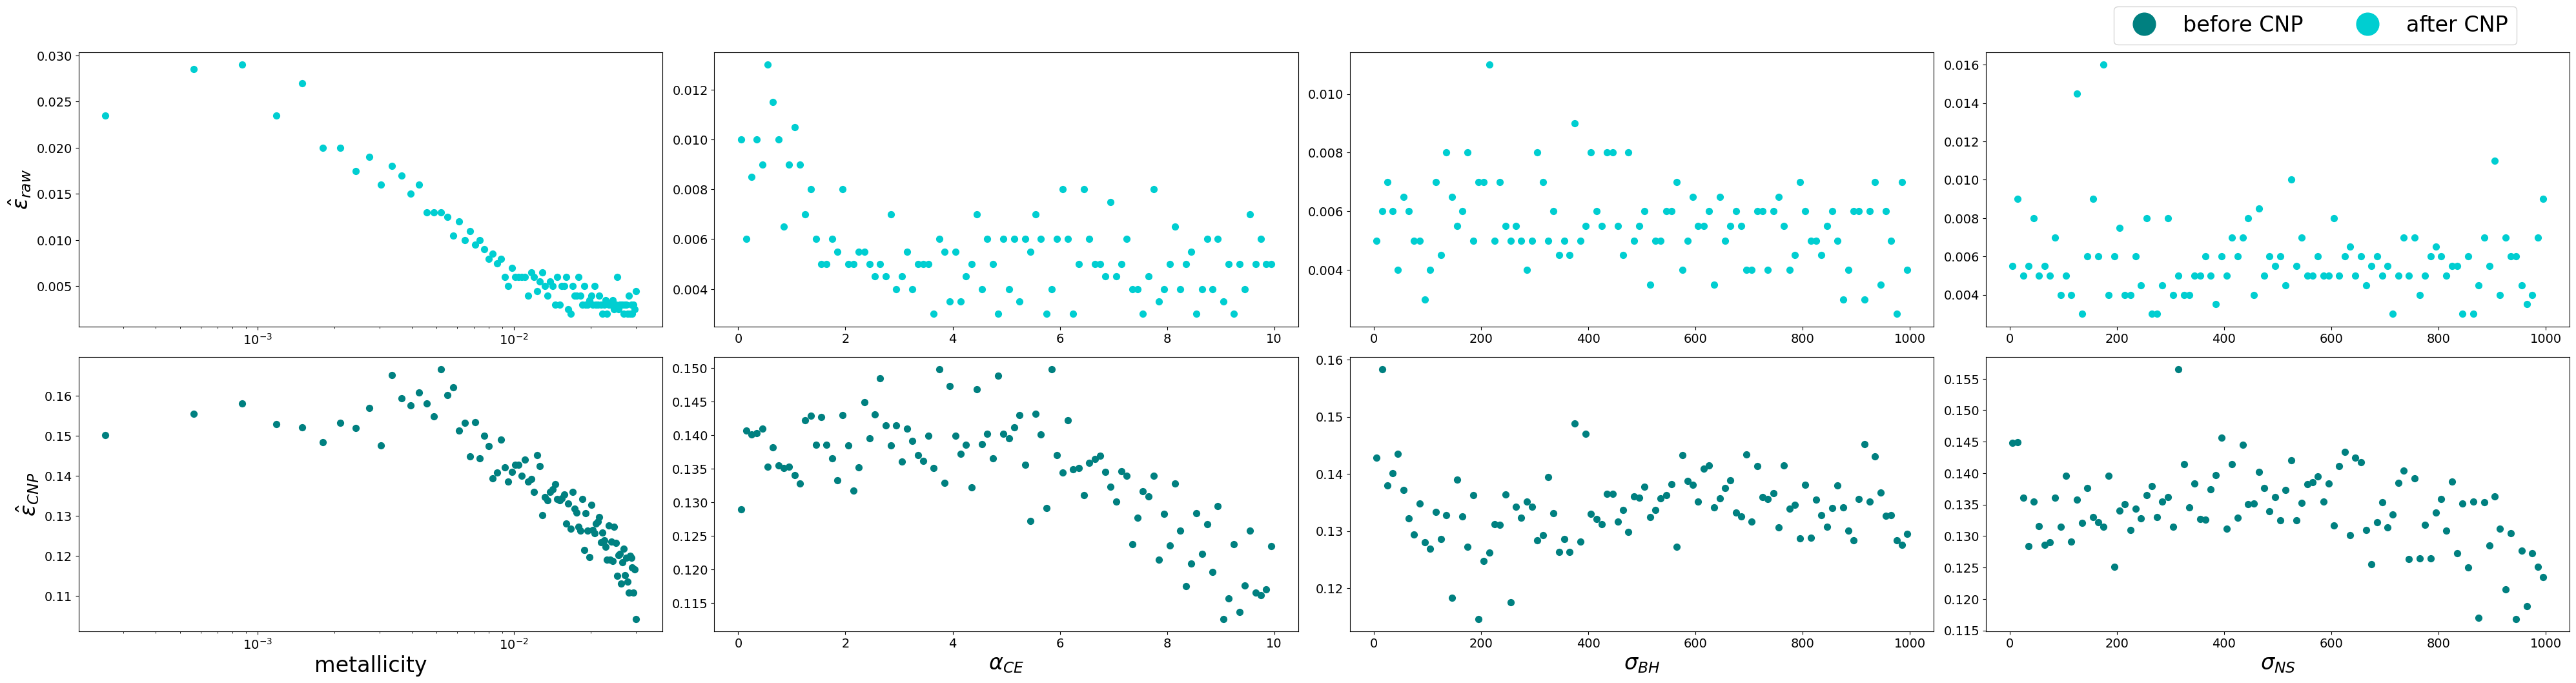

In [ ]:
fig=get_marginialized_all(config_file=config_file)

fig.savefig(f'{path_out}/cnp_{version}_output.png')